# 0. Import des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, Callback
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import backend as K

2024-07-07 16:26:17.119829: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 16:26:17.452999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 16:26:18.478765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Configuration GPU

In [2]:
# Configurer TensorFlow pour utiliser le GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


2024-07-07 16:26:21.895311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-07 16:26:22.049891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-07 16:26:22.051532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### 1.1 Utilisation de la précision Mixte et du clear pour libérer de la mémoire

#### Réduit la consommation de mémoire et accélère l'entraînement.

In [3]:
# Activer la précision mixte
from tensorflow.keras.mixed_precision import Policy
policy = Policy('mixed_float16') # Précision mixte 16 bits, plus rapide sur les GPU compatibles et économise de la mémoire
tf.keras.mixed_precision.set_global_policy(policy) # Appliquer la politique de précision mixte à toutes les opérations de keras

#### Libère la mémoire pour éviter des erreurs de saturation de mémoire.

In [4]:
# Nettoyage de la mémoire (au cas où :D)
K.clear_session() # Nettoyer la session Keras pour éviter les fuites de mémoire

# 2. Paramétrage

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8 # Plus la taille du lot est grande, plus l'entraînement est rapide, mais nécessite plus de mémoire
EPOCHS = 50 # Plus d'époques signifie plus de temps d'entraînement, mais peut être nécessaire pour obtenir une meilleure précision
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_VAL = CWD / "sorted_data" / "val"
NEW_TEST = CWD / "sorted_data" / "test"
class_names = {0: 'NORMAL', 1: 'VIRUS', 2: 'BACTERIA'}

# 3. Chargement des Datasets prétraités.

In [6]:
# Utiliser image_dataset_from_directory pour charger les datasets directement depuis un répertoire :)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TRAIN, # Le répertoire contenant les images (pour le training)
    labels='inferred', # Les labels récupèrent les noms des repertoires
    label_mode='categorical', # Les labels sont classés en catégories exemple : [0, 1, 0] pour une image de virus et [1, 0, 0] pour une image de normal
    color_mode='rgb', # Les images sont en couleur
    batch_size=BATCH_SIZE, # La taille du batch
    image_size=IMG_SIZE, # La taille des images
    shuffle=True # Mélanger les images à chaque epoch (pour éviter le surapprentissage)
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_VAL, # Le répertoire contenant les images (pour la validation)
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TEST, # Le répertoire contenant les images (pour le test)
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Appliquer le prétraitement spécifique à VGG16, qui consiste à normaliser les valeurs des pixels entre -1 et 1.
def preprocess(image, label):
    return preprocess_input(image), label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Mélanger les images et les mettre en cache pour accélérer le processus de lecture
# et précharger les images pour accélérer le processus d'entraînement.
# (cela permet de lire les images du disque en parallèle avec l'entraînement du modèle) eeet donc d'accélérer le processus d'entraînement.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 12484 files belonging to 3 classes.
Found 288 files belonging to 3 classes.
Found 822 files belonging to 3 classes.


### 4.1 Rajoute un peu de données modifiées pour améliorer la généralisation et rendre plus robuste le modèle

In [7]:
# Augmentation des données
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'), # Retourner horizontalement les images
    RandomRotation(0.2), # Faire une rotation de 20% des images
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# 5. Chargement du modèle et création des couches personnalisées 

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
# On récupère les poids de VGG16 pré-entraîné sur ImageNet
# On ne prend pas la dernière couche de VGG16 (include_top=False) car on va ajouter notre propre classifieur
# On spécifie la taille des images en entrée (224, 224, 3), la taille en pixels et les couleurs (RGB)


x = base_model.output # On récupère la sortie de VGG16
x = Flatten(name='new_flatten')(x) # On applatit les données pour les passer dans notre propre classifieur
x = Dense(320, activation='relu', kernel_regularizer=l2(0.001))(x) # On ajoute une couche dense de 320 neurones avec une régularisation L2
# (régularisation pour éviter le surapprentissage), contrainte qui pousse les poids vers 0 pour éviter les valeurs extrêmes.
# On utilise la fonction d'activation ReLU (Rectified Linear Unit) qui permet de passer les valeurs négatives à 0 et les valeurs positives inchangées.
x = BatchNormalization()(x) # Normalisation des données pour accélérer l'entraînement et éviter le surapprentissage
x = Dropout(0.6)(x) # Dropout de 60% pour éviter le surapprentissage
# le dropout permet de désactiver aléatoirement 60% des neurones à chaque epoch pour éviter le surapprentissage
x = Dense(320, activation='relu', kernel_regularizer=l2(0.001))(x) 
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
classifieur = Dense(3, activation='softmax', dtype='float32')(x)  # 3 classes: NORMAL, BACTERIA, VIRUS
# activation softmax pour obtenir des probabilités pour chaque classe (la somme des probabilités est égale à 1)
# dtype='float32' pour utiliser la précision mixte 16 bits que nous avons mis en place plus tôt, pour accélérer l'entraînement


new_model = Model(inputs=base_model.input, outputs=classifieur) # On crée un nouveau modèle avec notre propre classifieur

# 5. Gestion des Couches du VGG : Feature Extractor

In [9]:
# Geler les couches de base
# Les couches de base de VGG16 sont déjà entraînées sur ImageNet, nous ne voulons pas les ré-entraîner !
for layer in base_model.layers:
    layer.trainable = False

### 5.1 Compilation du modèle 

In [10]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])
# On utilise Adam comme optimiseur, une méthode de descente de gradient stochastique très efficace
# gradient stochastic descent => méthode d'optimisation pour minimiser la fonction de coût (perte)
# Adam est une méthode d'optimisation qui calcule des taux d'apprentissage adaptatifs pour chaque paramètre
# Adam est très efficace pour les réseaux de neurones profonds

# On utilise un taux d'apprentissage de 0.0001, car c'est le meilleur taux d'apprentissage obtenu avec kt.randomsearch

# On utilise la perte categorical_crossentropy pour les problèmes de classification multi-classes
# Compare les probabilités prédites par le modèle aux probabilités réelles des classes (one-hot encoded) (rappel : [0, 1, 0] => virus)

# On utilise la métrique accuracy pour mesurer la précision du modèle
# On utilise la métrique Recall pour mesurer la capacité à détecter les vrais positifs

new_model.summary() # Afficher un résumé du modèle

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 8,133,443 (31.03 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

### 5.2 Callbacks pour l'entrainement

In [11]:
# Callbacks pour l'entraînement
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))
    
    # Réduire le taux d'apprentissage de 10% à chaque epoch après la 10ème epoch 

In [12]:
lr_scheduler = LearningRateScheduler(scheduler) # Appeler la fonction scheduler à chaque epoch pour ajuster le taux d'apprentissage

In [13]:
es = EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=10,
    restore_best_weights=True
)
# Callback pour arrêter l'entraînement si la perte de validation n'a pas diminué pendant 10 epochs consécutives
# restore_best_weights=True pour restaurer les meilleurs poids du modèle


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6
)
# Réduire le taux d'apprentissage de 20% si la perte de validation n'a pas diminué pendant 3 epochs consécutives
# min_lr=1e-6 pour définir le taux d'apprentissage minimum à 1e-6

# Callback pour évaluation intermédiaire
class IntermediateEvaluation(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Evaluate every 5 epochs
            test_loss, test_accuracy, test_recall = self.model.evaluate(test_dataset)
            print(f"Epoch {epoch} - Test loss: {test_loss}, Test accuracy: {test_accuracy}, Test recall: {test_recall}")

# Permet d'évaluer le modèle sur le jeu de test à chaque 5 epochs :)

### 5.3 L'entrainement 

In [14]:
callbacks = [es, reduce_lr, lr_scheduler, IntermediateEvaluation()] 

history = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, # Utiliser le jeu de validation pour évaluer le modèle à la fin de chaque epoch
    epochs=EPOCHS, 
    callbacks=callbacks,
    shuffle=True # Mélanger les images à chaque epoch
)

Epoch 1/50


I0000 00:00:1720362392.617819    4811 service.cc:145] XLA service 0x768d9c024100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720362392.618126    4811 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-07-07 16:26:32.783961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-07 16:26:33.114892: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   3/1561 ━━━━━━━━━━━━━━━━━━━━ 1:15 48ms/step - accuracy: 0.3750 - loss: 2.9717 - recall: 0.3750  

I0000 00:00:1720362398.827909    4811 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.8301 - loss: 1.4018 - recall: 0.8180
Epoch 0 - Test loss: 1.7292393445968628, Test accuracy: 0.7214111685752869, Test recall: 0.7055960893630981
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 95s 52ms/step - accuracy: 0.5397 - loss: 2.3002 - recall: 0.5186 - val_accuracy: 0.6979 - val_loss: 1.6135 - val_recall: 0.6771 - learning_rate: 1.0000e-04
Epoch 2/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 68s 44ms/step - accuracy: 0.6408 - loss: 1.8714 - recall: 0.6246 - val_accuracy: 0.7500 - val_loss: 1.4512 - val_recall: 0.7396 - learning_rate: 1.0000e-04
Epoch 3/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.6665 - loss: 1.6903 - recall: 0.6500 - val_accuracy: 0.7500 - val_loss: 1.3713 - val_recall: 0.7326 - learning_rate: 1.0000e-04
Epoch 4/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.6849 - loss: 1.5412 - recall: 0.6628 - val_accuracy: 0.7535 - val_loss: 1.2976 - val_recall: 0.7361 - learning_rate: 1.0000e-04
Epoch 5/50
1561/15

### 5.4 Evaluation des performances 

In [15]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8941 - loss: 0.5474 - recall: 0.8870
Loss on test dataset: 0.7418126463890076
Accuracy on test dataset: 0.8175182342529297
Recall on test dataset: 0.8053528070449829


In [16]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [17]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

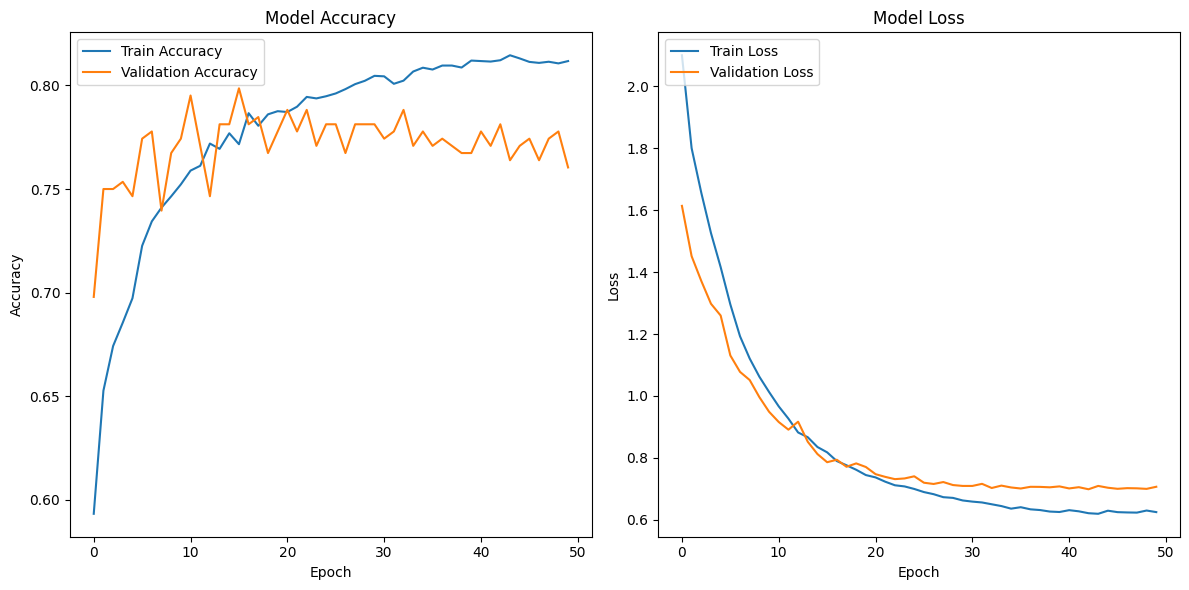

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8941 - loss: 0.5474 - recall: 0.8870
Loss on test dataset: 0.7418126463890076
Accuracy on test dataset: 0.8175182342529297
Recall on test dataset: 0.8053528070449829


2024-07-07 17:23:48.083494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


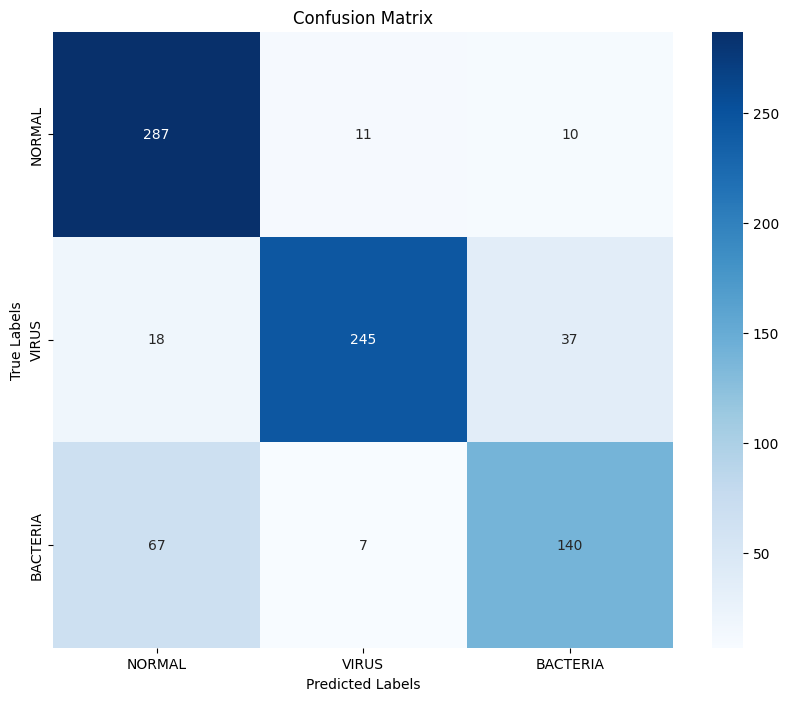

              precision    recall  f1-score   support

      NORMAL       0.77      0.93      0.84       308
       VIRUS       0.93      0.82      0.87       300
    BACTERIA       0.75      0.65      0.70       214

    accuracy                           0.82       822
   macro avg       0.82      0.80      0.80       822
weighted avg       0.82      0.82      0.82       822



In [18]:
# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)

# 6. Fine tuning : (partiel) 4 dernières couches

In [19]:
# Dégelez les dernières couches du modèle de base pour le fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [20]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 15,212,867 (58.03 MB)

 Non-trainable params: 7,636,544 (29.13 MB)

In [21]:
history_finetune = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=40,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8166 - loss: 0.8762 - recall_1: 0.7888
Epoch 0 - Test loss: 1.1130505800247192, Test accuracy: 0.6995133757591248, Test recall: 0.6593673825263977
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 103s 64ms/step - accuracy: 0.6620 - loss: 0.9303 - recall_1: 0.6222 - val_accuracy: 0.5938 - val_loss: 1.3661 - val_recall_1: 0.5521 - learning_rate: 1.0000e-04
Epoch 2/40
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.7106 - loss: 0.7860 - recall_1: 0.6691 - val_accuracy: 0.3576 - val_loss: 3.9590 - val_recall_1: 0.3576 - learning_rate: 1.0000e-04
Epoch 3/40
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.6808 - loss: 0.8054 - recall_1: 0.6243 - val_accuracy: 0.6215 - val_loss: 0.8298 - val_recall_1: 0.5556 - learning_rate: 1.0000e-04
Epoch 4/40
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.6894 - loss: 0.7806 - recall_1: 0.6269 - val_accuracy: 0.5625 - val_loss: 1.1959 - val_recall_1: 0.5590 - learning_rate:

In [22]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9045 - loss: 0.4008 - recall_1: 0.8987
Loss on test dataset: 0.5741881132125854
Accuracy on test dataset: 0.8248175382614136
Recall on test dataset: 0.8150851726531982


### 6.1 Sauvegarde du modèle

In [23]:
# Sauvegarder le modèle, pour le réutiliser plus tard sans avoir à le ré-entraîner
new_model.save('8_modele_final_fine_tuning_20_updated1_w_params.keras')

In [24]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [25]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

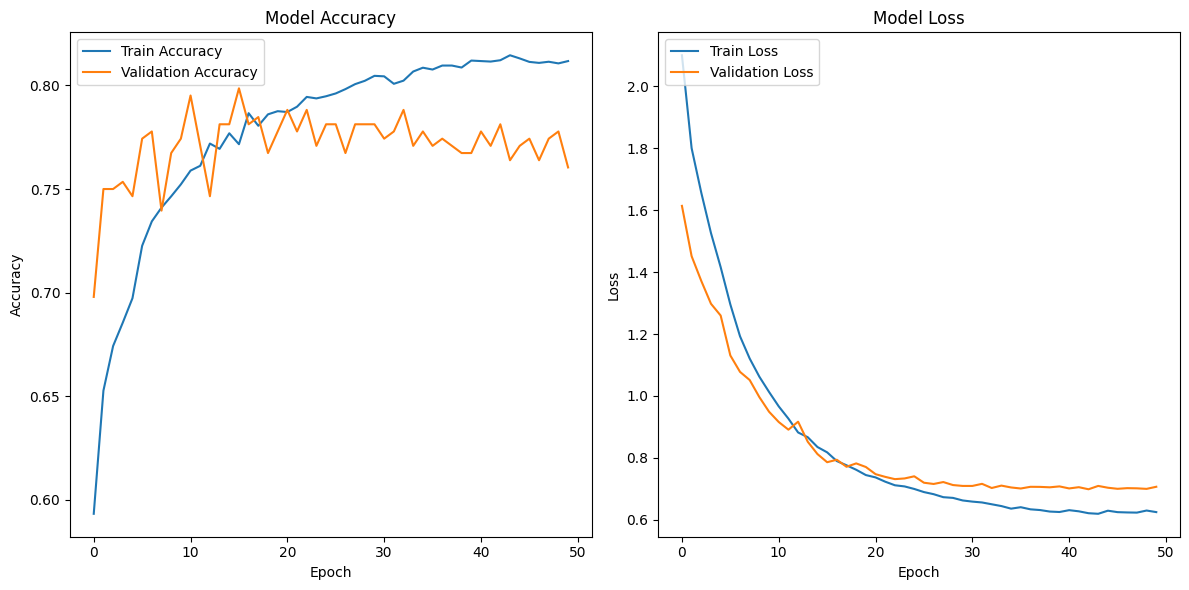

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9045 - loss: 0.4008 - recall_1: 0.8987
Loss on test dataset: 0.5741881132125854
Accuracy on test dataset: 0.8248175382614136
Recall on test dataset: 0.8150851726531982


2024-07-07 18:06:26.161675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


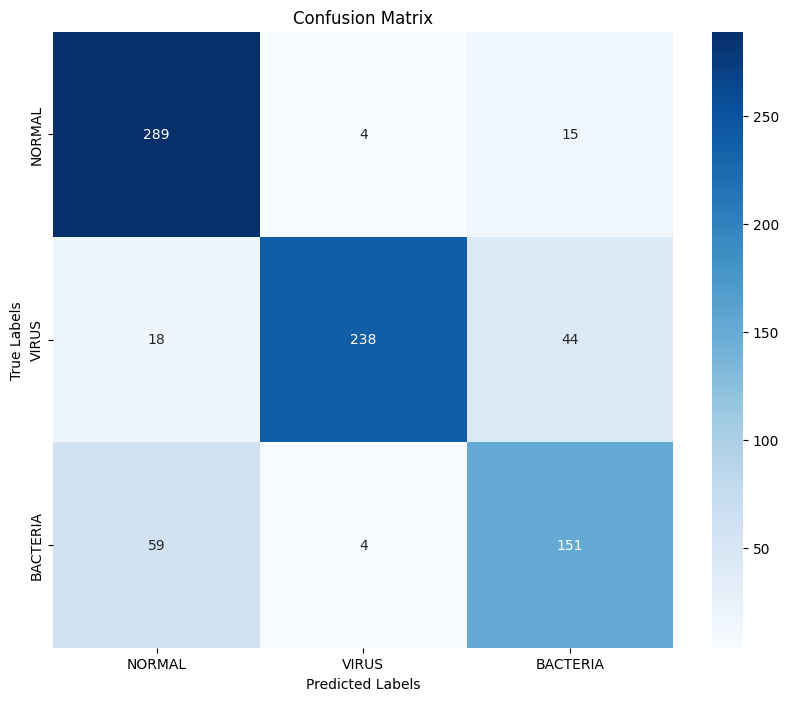

              precision    recall  f1-score   support

      NORMAL       0.79      0.94      0.86       308
       VIRUS       0.97      0.79      0.87       300
    BACTERIA       0.72      0.71      0.71       214

    accuracy                           0.82       822
   macro avg       0.83      0.81      0.81       822
weighted avg       0.84      0.82      0.82       822



In [26]:
# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)

# 7. Fine Tuning : (partiel) 8 dernières couches

In [27]:
# Dégelez les 8 dernières couches du modèle de base pour le fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [28]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 21,112,643 (80.54 MB)

 Non-trainable params: 1,736,768 (6.63 MB)

In [29]:
history_finetune_2 = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs= 30, 
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/30


2024-07-07 18:06:35.226605: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-07-07 18:06:35.789517: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 591/1561 ━━━━━━━━━━━━━━━━━━━━ 1:19 82ms/step - accuracy: 0.6519 - loss: 0.8398 - recall_2: 0.6188

2024-07-07 18:07:27.316528: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8071 - loss: 0.8660 - recall_2: 0.8044
Epoch 0 - Test loss: 1.671742558479309, Test accuracy: 0.5024330615997314, Test recall: 0.49756690859794617
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 143s 87ms/step - accuracy: 0.6851 - loss: 0.7551 - recall_2: 0.6541 - val_accuracy: 0.4757 - val_loss: 1.5163 - val_recall_2: 0.4722 - learning_rate: 1.0000e-04
Epoch 2/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.7324 - loss: 0.6512 - recall_2: 0.7038 - val_accuracy: 0.5208 - val_loss: 1.2430 - val_recall_2: 0.4931 - learning_rate: 1.0000e-04
Epoch 3/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.7476 - loss: 0.6292 - recall_2: 0.7126 - val_accuracy: 0.7153 - val_loss: 31.8659 - val_recall_2: 0.6771 - learning_rate: 1.0000e-04
Epoch 4/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.7759 - loss: 0.5706 - recall_2: 0.7514 - val_accuracy: 0.6354 - val_loss: 0.8032 - val_recall_2: 0.5972 - learning_rate: 1.0000

In [30]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8793 - loss: 0.4856 - recall_2: 0.8766
Loss on test dataset: 0.7041873931884766
Accuracy on test dataset: 0.8041362762451172
Recall on test dataset: 0.7992700934410095


In [31]:
# Sauvegarder le modèle
new_model.save('8_modele_final_fine_tuning_40_updated1_w_params.keras')

In [32]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [33]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

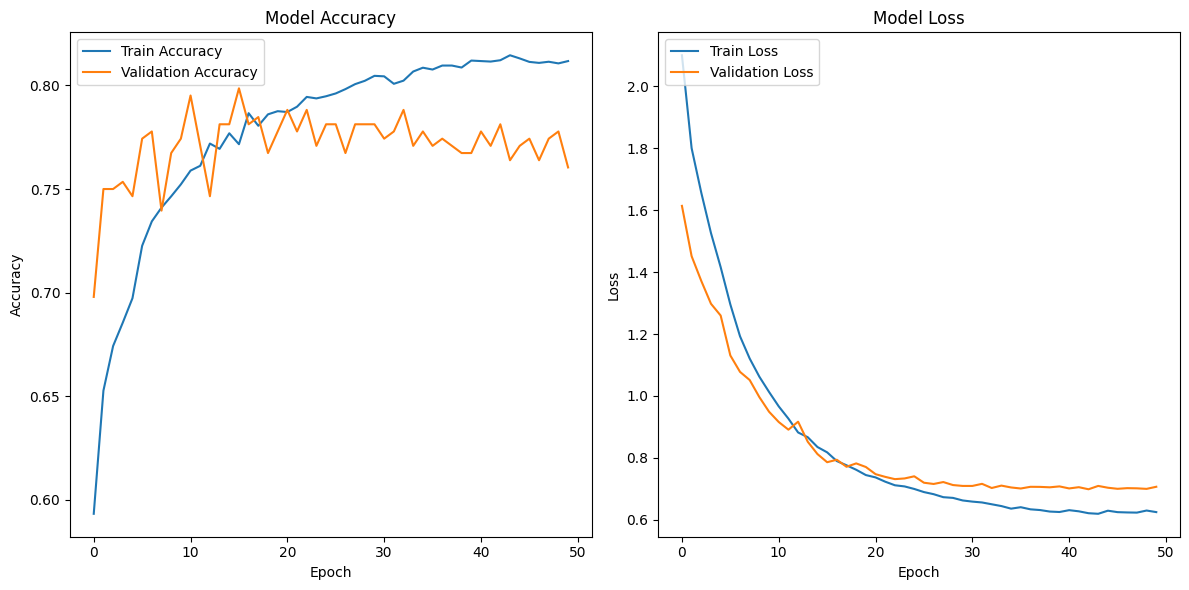

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8793 - loss: 0.4856 - recall_2: 0.8766
Loss on test dataset: 0.7041873931884766
Accuracy on test dataset: 0.8041362762451172
Recall on test dataset: 0.7992700934410095


2024-07-07 18:54:09.630918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


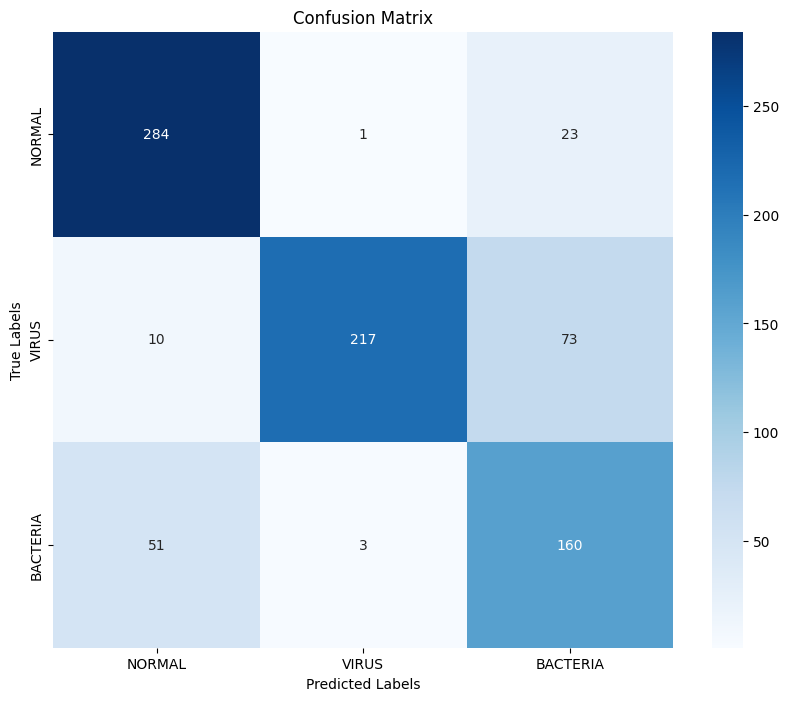

              precision    recall  f1-score   support

      NORMAL       0.82      0.92      0.87       308
       VIRUS       0.98      0.72      0.83       300
    BACTERIA       0.62      0.75      0.68       214

    accuracy                           0.80       822
   macro avg       0.81      0.80      0.79       822
weighted avg       0.83      0.80      0.81       822



In [34]:
# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)

# 8. Fine Tuning : Complet

In [35]:
# Fine-tuning final avec toutes les couches dégélées
for layer in base_model.layers:
    layer.trainable = True

In [36]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 22,848,131 (87.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [37]:
history_finetune_3 = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/50


2024-07-07 18:54:22.893565: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-07 18:54:24.398195: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-07 18:54:25.476604: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   1/1561 ━━━━━━━━━━━━━━━━━━━━ 5:42:55 13s/step - accuracy: 1.0000 - loss: 0.3208 - recall_3: 1.0000

I0000 00:00:1720371267.146297    4811 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 36 bytes spill stores, 36 bytes spill loads



 625/1561 ━━━━━━━━━━━━━━━━━━━━ 2:10 139ms/step - accuracy: 0.6849 - loss: 0.7574 - recall_3: 0.6580

2024-07-07 18:55:57.876796: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-07 18:55:58.679914: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-07 18:55:59.281641: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 626/1561 ━━━━━━━━━━━━━━━━━━━━ 2:20 150ms/step - accuracy: 0.6850 - loss: 0.7573 - recall_3: 0.6581

I0000 00:00:1720371360.984456    4811 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 36 bytes spill stores, 36 bytes spill loads



103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8980 - loss: 0.4323 - recall_3: 0.8919
Epoch 0 - Test loss: 0.8427099585533142, Test accuracy: 0.6812652349472046, Test recall: 0.6715328693389893
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 243s 148ms/step - accuracy: 0.7090 - loss: 0.7065 - recall_3: 0.6815 - val_accuracy: 0.6285 - val_loss: 0.6703 - val_recall_3: 0.6146 - learning_rate: 1.0000e-04
Epoch 2/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 219s 140ms/step - accuracy: 0.7731 - loss: 0.5673 - recall_3: 0.7540 - val_accuracy: 0.6597 - val_loss: 0.7254 - val_recall_3: 0.6319 - learning_rate: 1.0000e-04
Epoch 3/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 218s 140ms/step - accuracy: 0.7789 - loss: 0.5394 - recall_3: 0.7606 - val_accuracy: 0.7292 - val_loss: 0.6307 - val_recall_3: 0.7014 - learning_rate: 1.0000e-04
Epoch 4/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 220s 141ms/step - accuracy: 0.7791 - loss: 0.5493 - recall_3: 0.7586 - val_accuracy: 0.4722 - val_loss: 1.9194 - val_recall_3: 0.4722 - learning_rate: 1.0

In [38]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8980 - loss: 0.4323 - recall_3: 0.8919
Loss on test dataset: 0.8427099585533142
Accuracy on test dataset: 0.6812652349472046
Recall on test dataset: 0.6715328693389893


In [39]:
# Sauvegarder le modèle
new_model.save('8_modele_final_fine_tuning_100_updated1_w_params.keras')

In [40]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [41]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

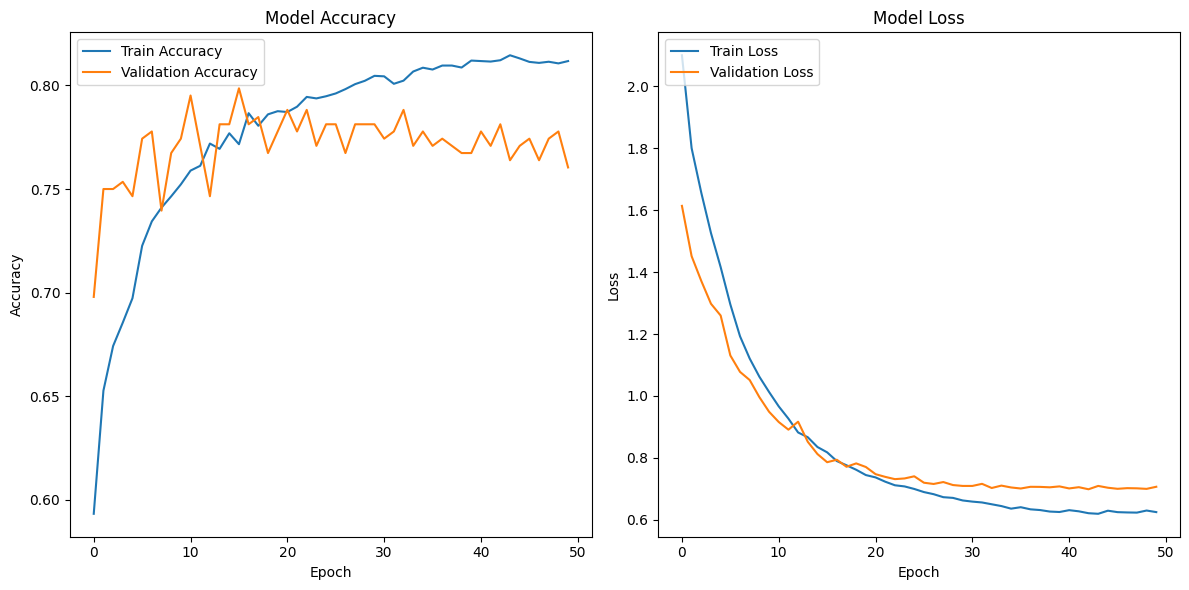

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8980 - loss: 0.4323 - recall_3: 0.8919
Loss on test dataset: 0.8427099585533142
Accuracy on test dataset: 0.6812652349472046
Recall on test dataset: 0.6715328693389893


2024-07-07 19:31:21.881367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


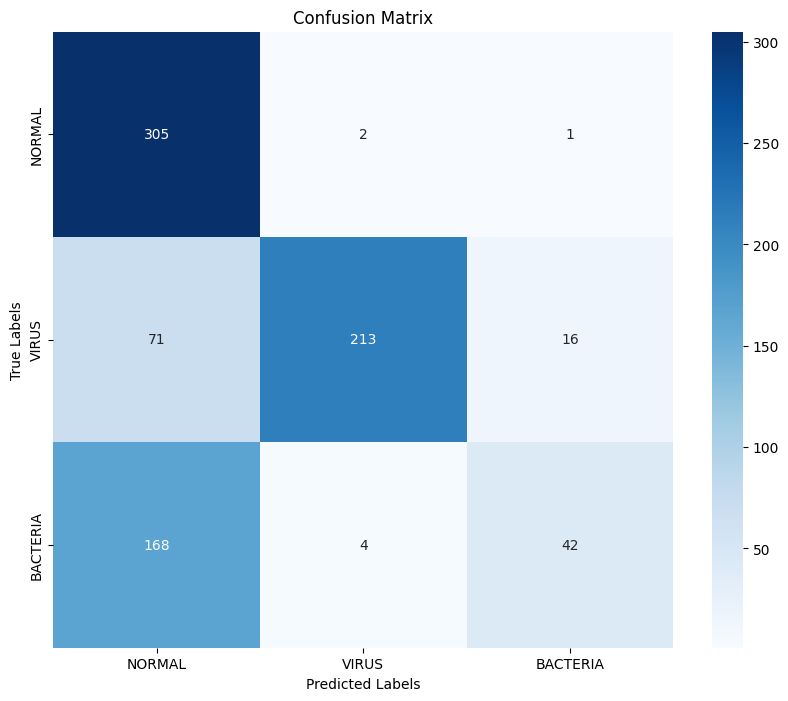

              precision    recall  f1-score   support

      NORMAL       0.56      0.99      0.72       308
       VIRUS       0.97      0.71      0.82       300
    BACTERIA       0.71      0.20      0.31       214

    accuracy                           0.68       822
   macro avg       0.75      0.63      0.61       822
weighted avg       0.75      0.68      0.65       822



In [42]:
# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)